In [6]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# to display matplotlib plots inline (directly below the cell)
%matplotlib inline

Using device: cpu


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),                   
    transforms.Normalize((0.1307,), (0.3081,))  
])

# get the MNIST dataset for training
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

full_test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

val_size = 5000
test_size = len(full_test_dataset) - val_size
val_dataset, test_dataset = torch.utils.data.random_split(full_test_dataset, [val_size, test_size])


# create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

validation_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of batches in training: {len(train_loader)}")
print(f"Number of batches in validation: {len(validation_loader)}")
print(f"Number of batches in testing: {len(test_loader)}")

Training dataset size: 60000
Validation dataset size: 5000
Test dataset size: 5000
Number of batches in training: 1875
Number of batches in validation: 157
Number of batches in testing: 157


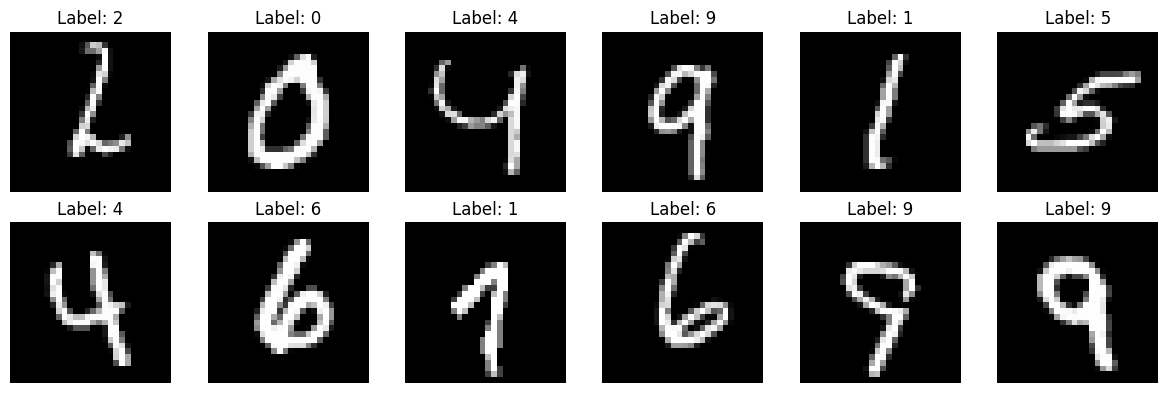

In [8]:
# get a batch of training data
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1)
    # remove normalization
    img = images[i].squeeze()
    img = img * 0.3081 + 0.1307
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [9]:
class PCMNISTNet(nn.Module):
    def __init__(self):
        super(PCMNISTNet, self).__init__()
        self.W1 = nn.Linear(28*28, 256, bias=True)
        self.W2 = nn.Linear(256, 128, bias=True)
        self.W3 = nn.Linear(128, 64, bias=True)
        self.W4 = nn.Linear(64, 10, bias=True)
        # lateral connections for hidden layers 2 and 3
        self.L2 = nn.Linear(128, 128, bias=True)
        self.L3 = nn.Linear(64, 64, bias=True)
        
        for layer in [self.L2, self.L3]:
            nn.init.normal_(layer.weight, mean=0.0, std=0.01)
            mask = ~torch.eye(layer.weight.shape[0], dtype=torch.bool)
            layer.weight.data *= mask # to avoid self connection
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)
                
        self.act = torch.relu

    def predict(self, x, lateral_strength=0.1):
        # forward pass to initialize latent states
        z0 = x.view(x.size(0), -1)
        z1 = self.act(self.W1(z0))
        z2_ff = self.act(self.W2(z1))
        lat2 = self.act(self.L2(z2_ff))
        z2 = z2_ff + lateral_strength * lat2
        z3_ff = self.act(self.W3(z2))
        lat3 = self.act(self.L3(z3_ff))
        z3 = z3_ff + lateral_strength * lat3
        z4 = self.W4(z3) # we want raw outputs here so no activation
        return [z0, z1, z2, z3, z4]

# Instantiate model
model = PCMNISTNet().to(device)
print(model)

PCMNISTNet(
  (W1): Linear(in_features=784, out_features=256, bias=True)
  (W2): Linear(in_features=256, out_features=128, bias=True)
  (W3): Linear(in_features=128, out_features=64, bias=True)
  (W4): Linear(in_features=64, out_features=10, bias=True)
  (L2): Linear(in_features=128, out_features=128, bias=True)
  (L3): Linear(in_features=64, out_features=64, bias=True)
)


In [10]:
inference_steps = 10
alpha = 0.05 # latent state learning rate
eta = 0.01 # weight learning rate
lateral_strength = 0.1

@torch.no_grad()
def pc_train_batch(model, x, y_onehot):
    zs = model.predict(x, lateral_strength=lateral_strength)
    Ws = [model.W1, model.W2, model.W3, model.W4]
    Ls = [model.L2, model.L3]
    L = len(Ws)
    batch_size = x.size(0)
    zs[L] = y_onehot # clamps z4 with the true labels
    for _ in range(inference_steps):
        errors = [None]*(L+1)
        for l in range(1, L+1):
            if l < L:
                ff_pred = model.act(Ws[l-1](zs[l-1]))
                if l == 2:
                    lat_pred = model.act(Ls[0](zs[l]))
                    pred = ff_pred + lateral_strength * lat_pred
                elif l == 3:
                    lat_pred = model.act(Ls[1](zs[l]))
                    pred = ff_pred + lateral_strength * lat_pred
                else:
                    pred = ff_pred
            else:
                pred = Ws[l-1](zs[l-1])
            errors[l] = zs[l] - pred

        # updating the activation states of the hidden layers
        for l in range(1, L):
            # the layer aligning itself with what the layer below says it should be
            td = -errors[l] 
            # push zl in the direction that would reduce the error one layer up
            bu = errors[l+1] @ Ws[l].weight 
            
            update = td + bu
            if l == 2:
                lat = lateral_strength * (errors[l] @ Ls[0].weight)
                update += lat
            elif l == 3:
                lat = lateral_strength * (errors[l] @ Ls[1].weight)
                update += lat
            
            zs[l] = model.act(zs[l] + alpha * update)

    # Final error calculation 
    final_errors = []
    for l in range(1, L+1):
        if l < L:
            ff_pred = model.act(Ws[l-1](zs[l-1]))
            if l == 2:
                lat_pred = model.act(Ls[0](zs[l]))
                pred = ff_pred + lateral_strength * lat_pred
            elif l == 3:
                lat_pred = model.act(Ls[1](zs[l]))
                pred = ff_pred + lateral_strength * lat_pred
            else:
                pred = ff_pred
        else:
            pred = Ws[l-1](zs[l-1])
        final_errors.append(zs[l] - pred)
        
    # Weight and bias updates 
    for i, W in enumerate(Ws):
        grad_w = final_errors[i].t() @ zs[i]
        W.weight.data += eta * (grad_w / batch_size) # we divide by the batch size to normalize the average gradient
        if W.bias is not None:
            grad_b = final_errors[i].sum(dim=0)
            W.bias.data += eta * (grad_b / batch_size)
            
    # Update lateral weights for layers 2 and 3
    for i, L_layer in enumerate(Ls):
        l = i + 2
        grad_w = final_errors[l-1].t() @ zs[l]
        mask = ~torch.eye(L_layer.weight.shape[0], dtype=torch.bool, device=grad_w.device)
        grad_w = grad_w * mask # to avoid self connection
        L_layer.weight.data += eta * lateral_strength * (grad_w / batch_size) 
        if L_layer.bias is not None:
            grad_b = final_errors[l-1].sum(dim=0)
            L_layer.bias.data += eta * lateral_strength * (grad_b / batch_size)  # we divide by the batch size to normalize the average gradient
            
# Evaluation function to calculate loss and accuracy
@torch.no_grad()
def evaluate_model(model, data_loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        
        zs = model.predict(images)
        preds = zs[-1].argmax(dim=1)
        
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        y_onehot = torch.zeros(images.size(0), 10, device=device)
        y_onehot.scatter_(1, labels.view(-1,1), 1.0)
        
        batch_loss = (zs[-1] - y_onehot).pow(2).mean().item()
        total_loss += batch_loss

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [11]:
num_epochs = 5 

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, num_epochs+1):
    model.train()
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}", leave=True):
        images, labels = images.to(device), labels.to(device)
        y_onehot = torch.zeros(images.size(0), 10, device=device)
        y_onehot.scatter_(1, labels.view(-1,1), 1.0)
        pc_train_batch(model, images, y_onehot)

    train_loss, train_acc = evaluate_model(model, train_loader)
    val_loss, val_acc = evaluate_model(model, validation_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Valid Loss: {val_loss:.4f} | Valid Acc: {val_acc:.4f}")

Epoch 1: 100%|██████████| 1875/1875 [00:41<00:00, 45.08it/s]


Epoch 1:
  Train Loss: 0.0612 | Train Acc: 0.6794
  Valid Loss: 0.0606 | Valid Acc: 0.6904


Epoch 2: 100%|██████████| 1875/1875 [00:35<00:00, 52.58it/s]


Epoch 2:
  Train Loss: 0.0501 | Train Acc: 0.7859
  Valid Loss: 0.0493 | Valid Acc: 0.8018


Epoch 3: 100%|██████████| 1875/1875 [00:39<00:00, 46.91it/s]


Epoch 3:
  Train Loss: 0.0463 | Train Acc: 0.8214
  Valid Loss: 0.0453 | Valid Acc: 0.8348


Epoch 4: 100%|██████████| 1875/1875 [00:38<00:00, 48.65it/s]


Epoch 4:
  Train Loss: 0.0445 | Train Acc: 0.8341
  Valid Loss: 0.0434 | Valid Acc: 0.8420


Epoch 5: 100%|██████████| 1875/1875 [00:35<00:00, 52.58it/s]


Epoch 5:
  Train Loss: 0.0436 | Train Acc: 0.8439
  Valid Loss: 0.0425 | Valid Acc: 0.8508
